In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
from PIL import Image
from IPython.display import display, HTML
import pandas as pd
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from io import BytesIO
import base64

In [7]:
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [8]:
directory = "/content/drive/My Drive/apple fruit"

In [9]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [10]:
def generate_caption_with_blip(image):
    inputs = blip_processor(images=image, return_tensors="pt")
    outputs = blip_model.generate(**inputs)
    return blip_processor.decode(outputs[0], skip_special_tokens=True)

In [11]:
def generate_caption_with_vit_gpt2(image):
    pixel_values = feature_extractor(images=[image], return_tensors="pt").pixel_values.to(device)
    output_ids = model.generate(pixel_values, max_length=16, num_beams=4)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption

In [12]:
def create_thumbnail(image):
    image.thumbnail((100, 100), Image.ANTIALIAS)
    buffer = BytesIO()
    image.save(buffer, format='JPEG')
    return base64.b64encode(buffer.getvalue()).decode()

In [13]:
def process_images(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(directory, filename)
            image = Image.open(image_path).convert("RGB")
            thumbnail = create_thumbnail(image)

            blip_caption = generate_caption_with_blip(image)
            vit_gpt2_caption = generate_caption_with_vit_gpt2(image)

            data.append({
                "Image": thumbnail,
                "BLIP Model Caption": blip_caption,
                "ViT-GPT2 Model Caption": vit_gpt2_caption
            })

    # Display results in a DataFrame
    df = pd.DataFrame(data)
    def image_formatter(im_base64):
        return f'<img src="data:image/jpeg;base64,{im_base64}" width="100px">'
    df['Image'] = df['Image'].apply(image_formatter)
    display(HTML(df.to_html(escape=False)))

<ipython-input-12-653c495a0126>:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image.thumbnail((100, 100), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


,Image,BLIP Model Caption,ViT-GPT2 Model Caption
0,,an apple with a leaf on top,a red apple sitting on top of a green apple
1,,an apple with a white background and a red apple,a red apple sitting on top of a table
2,,an apple hanging from a tree branch,a red apple sitting on top of a tree branch
3,,an apple on a black surface,a red apple sitting on top of a table
4,,an apple with a leaf on top,a red apple sitting on top of a green apple
5,,a bowl of apples on a table,a pile of apples sitting on top of a wooden table
6,,an apple with a leaf on top of it,a red apple sitting on top of a white surface
7,,an apple with water droplets on it,a red apple sitting on top of a red apple
8,,a bowl of apples sitting on top of a table,a pile of apples sitting on top of each other
9,,an apple with a white background,a red apple sitting on top of a table

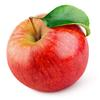
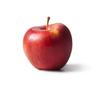
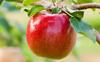
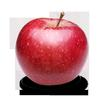
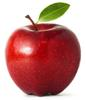
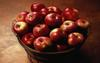
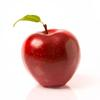
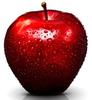
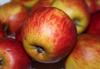
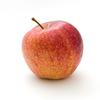
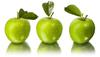
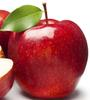
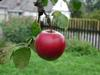
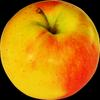
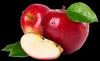
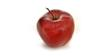
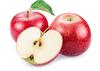
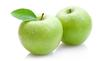
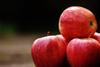
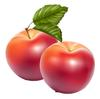
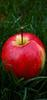
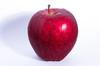
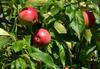
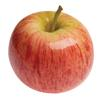
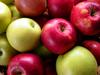
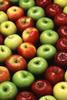
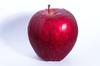
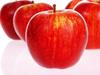
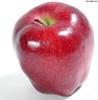
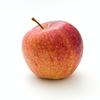
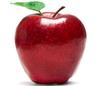
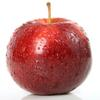
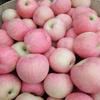
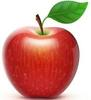
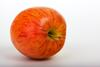
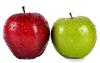
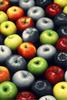
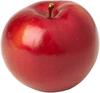
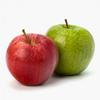
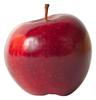

In [14]:
process_images(directory)
